In [1]:
import matplotlib.pyplot as plt
import cv2
import numpy as np 
import pandas as pd
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, Reshape,LeakyReLU, Dropout
import tensorflow as tf
from tensorflow.keras.layers import AveragePooling2D,UpSampling2D
from tensorflow import keras
from keras.callbacks import ModelCheckpoint

INFO:tensorflow:Enabling eager execution
INFO:tensorflow:Enabling v2 tensorshape
INFO:tensorflow:Enabling resource variables
INFO:tensorflow:Enabling tensor equality
INFO:tensorflow:Enabling control flow v2


In [2]:
ab = np.load('ab1.npy')
gray = np.load('gray_scale.npy')

In [3]:
def batch_prep(gray_img,batch_size=100):
  img=np.zeros((batch_size,224,224,3))
  # input to CNN interms of batchsize, height, width, depth(=3 as rgb as working with both rgb and grayscale image)
  # creating a array of zeros
  for i in range(0,3):
    img[:batch_size,:,:,i]=gray_img[batch_size+1:1+batch_size+batch_size]
    # iterate through each channel and get the batch size of the gray scale image
    # and store it in the empty array img
  return img
    # returning to img_in
img_in=batch_prep(gray,batch_size=300)
#staring with a intial batch size of 300 and pass gray images to represent the gray image in 3 channels

# A function to  represent in 3 channel

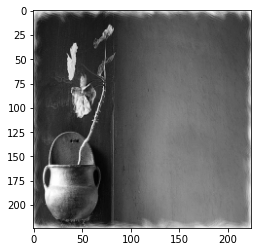

In [4]:
plt.imshow(gray[16],cmap=plt.cm.gray)
# viewing processed grey images

In [5]:
gray.shape
# initial sizes

(25000, 224, 224)

In [6]:
img_in.shape
# after conversion

(300, 224, 224, 3)

In [7]:
# As learning from colorful image and their corresponding grayscale images, so we craete a data
def get_rgb(gray_imgs,ab_imgs,n=10):
  img1=np.zeros((n,224,224,3))
  # n is batchsize 
  img1[:,:,:,0]=gray_imgs[n+1:n+n+1:]
  img1[:,:,:,1:]=ab_imgs[n+1:n+n+1]
  # 0 and 1 indicate where i want to allocate gray and color img
  # convert image to unit8(8 bit unsigned int format) format- to make it easier for the cv library to format
  img1=img1.astype("uint8")
  imgs=[]
  for i in range(0,n):
    imgs.append(cv2.cvtColor(img1[i],cv2.COLOR_LAB2RGB))
    # covert the images to colorspace from lab to rgb by iterating over the images
  imgs=np.array(imgs)
  # creating a numpy array of from the images matrix
  return imgs




In [8]:
img_out=get_rgb(gray_imgs=gray,ab_imgs=ab,n=300)
# calling the previous function

In [9]:
# for sequential flow of data
model=Sequential()
# creating cov2d layer
# Stride=no of pixels shifted, kernel size=3*3(extracts colors rgb from th image after dot product),filters tell number of kernels,bias is set to true ,
# and add additional weight automatically for fast convergence,padding is valid as all images of the same size and no padding is required, relu activation best for images
# Kernel extracts rgb from
model.add(Conv2D(strides=1,kernel_size=3,filters=8,use_bias=True,bias_initializer=tf.keras.initializers.RandomUniform(minval=-0.05,maxval=0.05),padding="valid",activation=tf.nn.relu))
# Conv2d transpose for upsampling, but here filters are 3
model.add(Conv2DTranspose(strides=1,kernel_size=3,filters=12,use_bias=True,bias_initializer=tf.keras.initializers.RandomUniform(minval=-0.05,maxval=0.05),padding="valid",activation=tf.nn.relu))
# All that is lost in leaky relu is relatively regained here if x<0.6 => 0.01*x, fixes dying relU issue
model.add(LeakyReLU(0.6))
# Avoids overfitting by setting dropout to 40% chance to set input to zero
model.add(Dropout(0.4))
# for further layers repeat these 

model.add(Conv2D(strides=1,kernel_size=3,filters=12,use_bias=True,bias_initializer=tf.keras.initializers.RandomUniform(minval=-0.05,maxval=0.05),padding="valid",activation=tf.nn.relu))
model.add(Conv2DTranspose(strides=1,kernel_size=3,filters=3,use_bias=True,bias_initializer=tf.keras.initializers.RandomUniform(minval=-0.05,maxval=0.05),padding="valid",activation=tf.nn.relu))
model.add(LeakyReLU(0.6))
model.add(Dropout(0.4))

model.add(Conv2D(strides=1,kernel_size=3,filters=12,use_bias=True,bias_initializer=tf.keras.initializers.RandomUniform(minval=-0.05,maxval=0.05),padding="valid",activation=tf.nn.relu))
model.add(Conv2DTranspose(strides=1,kernel_size=3,filters=3,use_bias=True,bias_initializer=tf.keras.initializers.RandomUniform(minval=-0.05,maxval=0.05),padding="valid",activation=tf.nn.relu))
model.add(LeakyReLU(0.6))
model.add(Dropout(0.4))

model.add(Conv2D(strides=1,kernel_size=3,filters=12,use_bias=True,bias_initializer=tf.keras.initializers.RandomUniform(minval=-0.05,maxval=0.05),padding="valid",activation=tf.nn.relu))
model.add(Conv2DTranspose(strides=1,kernel_size=3,filters=3,use_bias=True,bias_initializer=tf.keras.initializers.RandomUniform(minval=-0.05,maxval=0.05),padding="valid",activation=tf.nn.relu))
# Average pooling in last second layer to get avg values from the image, and making sure that image in anysize will be recognised
model.add(AveragePooling2D(pool_size=(2,2)))
# Average pooling by 2*2 will reduce the size of the image, so upsample the image(double) to regain the original size
model.add(UpSampling2D((2,2)))
model.add(LeakyReLU(0.6))
model.add(Dropout(0.4))

# Not doing the avg pooling in last layer as the that is the classifictaion layer and needn't be played around with.
model.add(Conv2D(strides=1,kernel_size=3,filters=12,use_bias=True,bias_initializer=tf.keras.initializers.RandomUniform(minval=-0.05,maxval=0.05),padding="valid",activation=tf.nn.relu))
model.add(Conv2DTranspose(strides=1,kernel_size=3,filters=3,use_bias=True,bias_initializer=tf.keras.initializers.RandomUniform(minval=-0.05,maxval=0.05),padding="valid",activation=tf.nn.relu))
model.add(LeakyReLU(0.6))
model.add(Dropout(0.4))

In [10]:
model.compile(optimizer=tf.keras.optimizers.Adam(clipvalue=0.5),loss='mape',metrics=tf.keras.metrics.Accuracy())
# Adam optimiser is used-->the arguement is used to avoid exploding gradient problem-->set gradient x between -0.5 and 0.5
# loss function is mape->extend of error interms of % mape=(summation(loss/expected value))/n
# Accuracy is used as performance metrics

In [11]:
checkpoint = ModelCheckpoint(filepath='CheckPointModel.h5',save_best_only=False, monitor='accuracy', mode='max', save_freq="epoch", verbose=1) 

In [12]:
model.fit(img_in,img_out,epochs=10,batch_size=16, callbacks = [checkpoint])
# training the cnn with worstcase batch size=16, input gray image, input rgb image and number of epochs

Epoch 1/10
19/19 [==============================] - 22s 1s/step - loss: 7321701.8125 - accuracy: 0.0650

Epoch 00001: saving model to CheckPointModel.h5
Epoch 2/10
19/19 [==============================] - 22s 1s/step - loss: 138.9251 - accuracy: 0.0652

Epoch 00002: saving model to CheckPointModel.h5
Epoch 3/10
19/19 [==============================] - 21s 1s/step - loss: 93.7634 - accuracy: 0.0624

Epoch 00003: saving model to CheckPointModel.h5
Epoch 4/10
19/19 [==============================] - 22s 1s/step - loss: 93.6429 - accuracy: 0.0636

Epoch 00004: saving model to CheckPointModel.h5
Epoch 5/10
19/19 [==============================] - 22s 1s/step - loss: 93.2486 - accuracy: 0.0675

Epoch 00005: saving model to CheckPointModel.h5
Epoch 6/10
19/19 [==============================] - 25s 1s/step - loss: 92.9439 - accuracy: 0.0706

Epoch 00006: saving model to CheckPointModel.h5
Epoch 7/10
19/19 [==============================] - 25s 1s/step - loss: 94.6221 - accuracy: 0.0538

Epoch 

In [14]:
prediction=model.predict(img_in)
# predicting

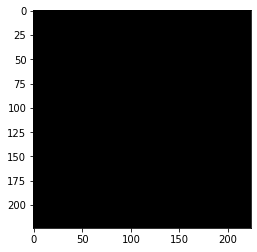

In [15]:
plt.imshow(prediction[40])
# viewing the prediction

In [ ]:
checkPointModel=tf.keras.models.load_model('CheckPointModel.h5')